## Setup

In [1]:
import pandas as pd
import numpy as np

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

FILE_PATH = "data_transportation_phd_recruitment.xlsx"
SHEET_PEOPLE = "People"

## Load data

In [2]:
people = pd.read_excel(FILE_PATH, sheet_name=SHEET_PEOPLE)

# preserve original row order explicitly (useful for pairing rule)
people = people.reset_index(drop=False).rename(columns={"index": "row_id"})

people.head()

,row_id,Institution,Name,Role,Rank_or_Year,UG_Institution,UG_Country,UG_Department,PhD_Institution,PhD_Country,PhD_Year_or_Start
0,0,Carnegie Mellon University,1,Professor,Full,Tsinghua University,China,Civil Engineering,UC Davis,USA,2006.0
1,1,Carnegie Mellon University,2,Student,NaN,Dalian University of Technology,China,Civil Engineering,Carnegie Mellon University,USA,2020.0
2,2,Carnegie Mellon University,3,Student,NaN,Reed College,USA,Physics,Carnegie Mellon University,USA,2022.0
3,3,Carnegie Mellon University,4,Student,NaN,Hong Kong Polytechnic University,China,Civil Engineering,Carnegie Mellon University,USA,2022.0
4,4,Carnegie Mellon University,5,Student,NaN,Hong Kong Polytechnic University,China,Geomatics,Carnegie Mellon University,USA,2023.0


## Utilities

In [3]:
def std_country_series(s: pd.Series) -> pd.Series:
    """Standardize country strings to canonical labels."""
    s = s.astype("string").str.strip()
    s = s.replace({"": pd.NA, "nan": pd.NA, "None": pd.NA})
    s = s.str.replace(r"\s+", " ", regex=True)
    low = s.str.lower()

    mapping = {
        "us": "United States",
        "u.s.": "United States",
        "u.s.a.": "United States",
        "usa": "United States",
        "united states of america": "United States",
        "united states": "United States",
        "prc": "China",
        "p.r. china": "China",
        "p.r.c.": "China",
        "people's republic of china": "China",
        "peoples republic of china": "China",
        "china": "China",
    }

    out = low.map(mapping)
    # if not mapped, fall back to title case of original (keeps e.g. "Bangladesh")
    fallback = s.where(out.isna(), pd.NA)
    fallback = fallback.astype("string")
    # Title-case but keep acronyms by leaving as-is if all caps and short
    fallback_tc = fallback.str.title()
    return out.fillna(fallback_tc)

In [4]:
def build_pairs_from_people(
    people: pd.DataFrame,
    professor_role_keywords=("prof", "faculty", "assistant professor", "associate professor", "full professor"),
    student_role_keywords=("phd", "student", "doctoral"),
    strict_student_rows: bool = True,
) -> pd.DataFrame:
    """
    Builds advisor–student pairs using the rule:
      the advisor is the closest professor row above.

    Returns a dataframe of student rows with attached advisor columns:
      Advisor_Name, Advisor_Institution, Advisor_Rank_or_Year, Advisor_Role, Advisor_Keyword_Evidence, Advisor_ID
    """
    df = people.copy()

    # normalize role text
    role = df["Role"].astype(str).str.strip().str.lower()
    df["_role_norm"] = role

    # mark professor rows
    prof_pat = "|".join([k.lower() for k in professor_role_keywords])
    df["_is_prof"] = df["_role_norm"].str.contains(prof_pat, na=False)

    # mark student rows
    stud_pat = "|".join([k.lower() for k in student_role_keywords])
    df["_is_student"] = df["_role_norm"].str.contains(stud_pat, na=False)

    # advisor fields exist only on professor rows, then forward fill down
    df["Advisor_Name"] = np.where(df["_is_prof"], df["Name"], pd.NA)
    df["Advisor_Institution"] = np.where(df["_is_prof"], df["Institution"], pd.NA)
    df["Advisor_Rank_or_Year"] = np.where(df["_is_prof"], df["Rank_or_Year"], pd.NA)
    df["Advisor_Role"] = np.where(df["_is_prof"], df["Role"], pd.NA)

    df[[
        "Advisor_Name",
        "Advisor_Institution",
        "Advisor_Rank_or_Year",
        "Advisor_Role",
    ]] = df[[
        "Advisor_Name",
        "Advisor_Institution",
        "Advisor_Rank_or_Year",
        "Advisor_Role",
    ]].ffill()

    # keep only student rows
    if strict_student_rows:
        pairs = df[df["_is_student"]].copy()
    else:
        pairs = df[~df["_is_prof"]].copy()

    # drop any student rows that appear before the first professor in a block
    pairs = pairs.dropna(subset=["Advisor_Name", "Advisor_Institution"]).copy()

    # stable advisor id
    pairs["Advisor_ID"] = (
        pairs["Advisor_Name"].astype("string").str.strip()
        + " | "
        + pairs["Advisor_Institution"].astype("string").str.strip()
    )

    # convenience
    pairs["Advisor_Institution"] = pairs["Advisor_Institution"].astype("string").str.strip()
    return pairs

# 4.

### 4.1 

In [5]:
import pandas as pd
import numpy as np

def _pick_id_col(df: pd.DataFrame, role: str):
    """
    Prefer an existing ID column. Otherwise create one.
    role is only used for nicer generated IDs.
    """
    candidates = [
        "Person_ID", "person_id", "ID", "id",
        "Anon_ID", "anon_id",
        "Student_ID", "student_id",
        "Advisor_ID", "advisor_id"
    ]
    for c in candidates:
        if c in df.columns:
            return c
    # fallback
    new_col = "Person_ID"
    df[new_col] = [f"{role}_{i:06d}" for i in range(len(df))]
    return new_col

def section41_overview_anonymized(people: pd.DataFrame):
    df = people.copy()

    # normalize
    for col in ["Role", "Institution"]:
        if col in df.columns:
            df[col] = df[col].astype("string").str.strip()

    # choose an ID column for raw roster counting
    person_id_col = _pick_id_col(df, role="person")

    prof = df[df["Role"].str.lower() == "professor"].copy()
    stud = df[df["Role"].str.lower() == "student"].copy()

    # counts on raw roster
    n_programs = int(prof["Institution"].nunique())

    # unique advisors: person id within institution
    n_advisors = int((prof[person_id_col].astype("string") + " | " +
                      prof["Institution"].astype("string")).nunique())

    # build pairs (your existing function)
    pairs = build_pairs_from_people(
        df,
        professor_role_keywords=("professor",),
        student_role_keywords=("student",),
        strict_student_rows=True,
    )

    n_pairs = int(len(pairs))

    # pick student identifier in pairs
    student_id_col = None
    for c in ["Student_ID", "student_id", person_id_col, "Person_ID", "ID", "id"]:
        if c in pairs.columns:
            student_id_col = c
            break
    if student_id_col is None:
        # last resort
        pairs["Student_ID"] = [f"student_{i:06d}" for i in range(len(pairs))]
        student_id_col = "Student_ID"

    n_students_paired = int(
        (pairs[student_id_col].astype("string") + " | " +
         pairs["Advisor_Institution"].astype("string")).nunique()
    )

    # students per advisor distribution
    if "Advisor_ID" in pairs.columns:
        roster = pairs.groupby("Advisor_ID").size()
    else:
        # fallback if your pairing function uses a different advisor id column
        adv_id_col = next((c for c in ["advisor_id", "AdvisorID", "Advisor"] if c in pairs.columns), None)
        roster = pairs.groupby(adv_id_col).size() if adv_id_col else pd.Series(dtype=int)

    med = float(roster.median()) if len(roster) else np.nan
    iqr = (float(roster.quantile(0.25)), float(roster.quantile(0.75))) if len(roster) else (np.nan, np.nan)

    # coverage (paired sample)
    student_ug_share = float(pairs["UG_Country"].notna().mean()) if "UG_Country" in pairs.columns else np.nan

    # advisor UG coverage (prof rows)
    if "UG_Country" in prof.columns:
        advisor_ug_share = float(
            prof.drop_duplicates(subset=[person_id_col, "Institution"])["UG_Country"].notna().mean()
        )
    else:
        advisor_ug_share = np.nan

    overview = pd.DataFrame(
        [
            ("Destination programs", n_programs),
            ("Advisors", n_advisors),
            ("Students (raw roster)", int((stud[person_id_col].astype("string") + " | " +
                                           stud["Institution"].astype("string")).nunique())),
            ("Students (paired)", n_students_paired),
            ("Advisor–student pairs", n_pairs),
            ("Students per advisor (median)", med),
            ("Students per advisor (IQR)", f"{iqr[0]} to {iqr[1]}"),
            ("Students with known UG country (paired share)", student_ug_share),
            ("Advisors with known UG country (share)", advisor_ug_share),
        ],
        columns=["Metric", "Value"],
    )

    return overview, pairs

# run
table_41, pairs = section41_overview_anonymized(people)
display(table_41)


,Metric,Value
0,Destination programs,23
1,Advisors,125
2,Students (raw roster),316
3,Students (paired),316
4,Advisor–student pairs,316
5,Students per advisor (median),4.0
6,Students per advisor (IQR),2.0 to 5.0
7,Students with known UG country (paired share),0.962025
8,Advisors with known UG country (share),0.968


### 4.2

In [6]:
import pandas as pd
import numpy as np

def section42_destination_programs(people: pd.DataFrame, pairs: pd.DataFrame = None, top_k: int = 5):
    """
    Section 4.2 Destination Programs:
    - number of programs
    - advisors per program (median, IQR)
    - pairs per program (median, IQR)
    - optional top-K table by advisor count (or pairs)

    Pass `pairs` from build_pairs_from_people(...) to keep everything consistent with Sections 5–6.
    """
    df = people.copy()
    df["Institution"] = df["Institution"].astype("string").str.strip()
    df["Name"] = df["Name"].astype("string").str.strip()
    df["Role"] = df["Role"].astype("string").str.strip()

    # build pairs if not provided
    if pairs is None:
        pairs = build_pairs_from_people(
            df,
            professor_role_keywords=("professor",),
            student_role_keywords=("student",),
            strict_student_rows=True,
        )

    # program-level counts based on paired sample
    prog = pairs.copy()
    prog["Destination_Program"] = prog["Advisor_Institution"].astype("string").str.strip()

    advisors_per_prog = prog.groupby("Destination_Program")["Advisor_ID"].nunique()
    pairs_per_prog = prog.groupby("Destination_Program").size().rename("n_pairs")

    n_programs = int(advisors_per_prog.shape[0])

    def _med_iqr(x: pd.Series):
        return float(x.median()), (float(x.quantile(0.25)), float(x.quantile(0.75)))

    adv_med, adv_iqr = _med_iqr(advisors_per_prog)
    pair_med, pair_iqr = _med_iqr(pairs_per_prog)

    # table: program composition (top K + Other)
    table_prog = (
        pd.DataFrame({
            "Destination_Program": advisors_per_prog.index,
            "n_advisors": advisors_per_prog.values,
        })
        .merge(pairs_per_prog.reset_index(), on="Destination_Program", how="left")
        .sort_values(["n_advisors", "n_pairs"], ascending=[False, False])
        .reset_index(drop=True)
    )

    top = table_prog.head(top_k).copy()
    other = table_prog.iloc[top_k:].copy()

    if len(other) > 0:
        other_row = pd.DataFrame([{
            "Destination_Program": "Other",
            "n_advisors": int(other["n_advisors"].sum()),
            "n_pairs": int(other["n_pairs"].sum()),
        }])
        table_topk = pd.concat([top, other_row], ignore_index=True)
    else:
        table_topk = top

    # summary dict for text
    summary = {
        "n_programs": n_programs,
        "advisors_per_program_median": adv_med,
        "advisors_per_program_iqr": adv_iqr,
        "pairs_per_program_median": pair_med,
        "pairs_per_program_iqr": pair_iqr,
    }

    return summary, table_prog, table_topk


# ---- run (recommended: reuse your existing pairs) ----
pairs = build_pairs_from_people(
    people,
    professor_role_keywords=("professor",),
    student_role_keywords=("student",),
    strict_student_rows=True,
)

summary_42, program_table_full, program_table_top = section42_destination_programs(
    people, pairs=pairs, top_k=5
)

print(summary_42)
# display(program_table_top)       # small table for paper
display(program_table_full)    # full program table if you want appendix

{'n_programs': 23, 'advisors_per_program_median': 3.0, 'advisors_per_program_iqr': (1.0, 5.0), 'pairs_per_program_median': 11.0, 'pairs_per_program_iqr': (5.0, 22.0)}


,Destination_Program,n_advisors,n_pairs
0,University of Illinois Urbana-Champaign,7,29
1,UC Davis,6,22
2,University of Texas Austin,6,22
3,Purdue University,5,31
4,MIT,5,29
5,University of Michigan Ann Arbor,5,23
6,UCLA,5,20
7,University of Washington,5,18
8,Georgia Institute of Technology,5,15
9,University of California Berkeley,4,11


### 4.3

In [7]:
students = people[
    people["Role"]
    .astype(str)
    .str.lower()
    .str.contains("phd|doctoral|student", regex=True, na=False)
].copy()

In [8]:
students["UG_Country"].value_counts().sort_values(ascending=False)

China           126
USA              76
Iran             20
India            13
South Korea      12
Bangladesh        9
Brazil            4
Thailand          4
Taiwan            4
Sri Lanka         2
Costa Rica        2
Saudi Arabia      2
Pakistan          2
Canada            2
Colombia          2
Indonesia         2
Nigeria           2
Lebanon           2
Mexico            2
Palestine         1
UK                1
Australia         1
Swiss             1
France            1
Turkey            1
Greece            1
Japan             1
Peru              1
Egypt             1
Italy             1
South Africa      1
Nepal             1
Israel            1
Kazakhstan        1
Chile             1
Name: UG_Country, dtype: int64

In [9]:
advisors = people[
    people["Role"]
    .astype(str)
    .str.lower()
    .str.contains("prof", regex=True, na=False)
].copy()

In [10]:
advisors["UG_Country"].value_counts().sort_values(ascending=False)

USA            43
China          29
India          10
Iran            6
Canada          4
Italy           3
Colombia        2
France          2
Spain           2
South Korea     2
Chile           2
Greece          2
Turkey          2
Lebanon         1
Venezuela       1
Argentina       1
Jordan          1
Israel          1
Swiss           1
Ghana           1
Sudan           1
Uruguay         1
Bangladesh      1
Egypt           1
Brazil          1
Name: UG_Country, dtype: int64

In [11]:
def map_ug_department(dept):
    if pd.isna(dept):
        return pd.NA
    d = dept.lower()
    if "civil" in d:
        return "Civil Engineering"
    if "transport" in d or "traffic" in d:
        return "Transportation Engineering"
    if "mechanical" in d:
        return "Mechanical Engineering"
    if "electrical" in d or 'electronic' in d or 'computer engineering' in d or "ee" == d:
        return "Electrical Engineering"
    if "computer" in d or "cs" == d:
        return "Computer Science"
    if "math" in d or "statistics" in d or "stat" in d:
        return "Mathematics / Statistics"
    if 'artificial' in d or 'data' in d:
        return 'AI / Data Science'
    if "physics" in d:
        return "Physics"
    if "industrial" in d or "operations" in d or 'supply' in d or 'logistic' in d or 'management' in d or "ie" == d:
        return "Industrial / Systems Engineering"
    if "econom" in d:
        return "Economics"
    if 'info' in d:
        return 'Information Science'

    if any(k in d for k in [
        "aero", "astronaut", "aircraft", "vehicle", "automotive"
    ]):
        return "Aero / Auto / Vehicle"

    if any(k in d for k in [
        "urban", "planning", "regional", "geography", "remote sensing"
    ]):
        return "Urban / Geo / Planning"

    if any(k in d for k in [
        "engineering", "robotics", "mechatronics", "materials",
        "manufacturing",
        "process", "hydropower", "water", "automation", "control",
        "safety"
    ]):
        return "Other Engineering"

    return "Other Non Engineering"

# Apply mapping
students["UG_Department_Grouped"] = students["UG_Department"].apply(map_ug_department)

# Counts
grouped_counts = (
    students["UG_Department_Grouped"]
    .value_counts(dropna=False)
    .rename_axis("UG_Department_Grouped")
    .reset_index(name="Count")
)
grouped_counts

,UG_Department_Grouped,Count
0,Civil Engineering,109
1,<NA>,44
2,Transportation Engineering,30
3,Computer Science,18
4,Industrial / Systems Engineering,17
5,Mechanical Engineering,16
6,Other Engineering,15
7,Electrical Engineering,12
8,Other Non Engineering,11
9,Aero / Auto / Vehicle,10


# 5. Advisor–Student Recruiting Dynamics

### 5.1 Defining advisor recruiting profiles

In [12]:
def define_advisor_recruiting_profiles_from_pairs(pairs: pd.DataFrame, min_students: int = 3):
    """
    Compute dominant recruiting country for each advisor using student UG country.

    Requires pairs contains student UG country column named 'UG_Country'.
    Produces:
      df_pairs with columns:
        Student_UG_Country_std, Advisor_Dominant_UG_Country, n_students_known_country, dom_share, is_stable
      advisor_profiles: one row per advisor
    """
    d = pairs.copy()

    # standardized student UG country column
    d["Student_UG_Country_std"] = std_country_series(d["UG_Country"]) if "UG_Country" in d.columns else pd.NA

    # profile uses only students with known UG country
    d_prof = d.dropna(subset=["Student_UG_Country_std"]).copy()
    if len(d_prof) == 0:
        raise ValueError("No student rows with non-missing UG_Country after cleaning.")

    ac = (
        d_prof.groupby(["Advisor_ID", "Student_UG_Country_std"])
              .size()
              .reset_index(name="n")
    )

    totals = (
        ac.groupby("Advisor_ID")["n"]
          .sum()
          .reset_index(name="n_students_known_country")
    )

    # dominant country by count; break ties by treating as NA (no unique dominant)
    ac_sorted = ac.sort_values(["Advisor_ID", "n", "Student_UG_Country_std"], ascending=[True, False, True])
    top = ac_sorted.groupby("Advisor_ID", as_index=False).head(2)

    def _dominant_or_na(g: pd.DataFrame):
        if len(g) == 1:
            return g.iloc[0]["Student_UG_Country_std"], g.iloc[0]["n"], True
        if g.iloc[0]["n"] == g.iloc[1]["n"]:
            return pd.NA, g.iloc[0]["n"], False
        return g.iloc[0]["Student_UG_Country_std"], g.iloc[0]["n"], True

    dom_rows = []
    for aid, g in top.groupby("Advisor_ID", sort=False):
        dom_c, n_dom, has_unique = _dominant_or_na(g.reset_index(drop=True))
        dom_rows.append({"Advisor_ID": aid, "Advisor_Dominant_UG_Country": dom_c, "n_dom": n_dom, "has_unique_dom": has_unique})

    dom = pd.DataFrame(dom_rows)

    advisor_profiles = dom.merge(totals, on="Advisor_ID", how="left")
    advisor_profiles["dom_share"] = advisor_profiles["n_dom"] / advisor_profiles["n_students_known_country"]
    advisor_profiles["is_stable"] = (advisor_profiles["n_students_known_country"] >= int(min_students)) & (advisor_profiles["has_unique_dom"] == True)

    df_pairs = d.merge(
        advisor_profiles[["Advisor_ID", "Advisor_Dominant_UG_Country", "n_students_known_country", "dom_share", "is_stable"]],
        on="Advisor_ID",
        how="left",
        validate="m:1",
    )

    return df_pairs, advisor_profiles


def table_51_from_df_pairs(df_pairs: pd.DataFrame) -> pd.DataFrame:
    stable = df_pairs[df_pairs["is_stable"] == True].copy()
    stable["Advisor_Dominant_UG_Country_std"] = stable["Advisor_Dominant_UG_Country"].astype("string").str.strip()

    return (
        stable.groupby("Advisor_Dominant_UG_Country_std")
              .agg(n_advisors=("Advisor_ID", "nunique"),
                   n_pairs=("Advisor_ID", "size"))
              .reset_index()
              .sort_values("n_pairs", ascending=False)
    )

In [ ]:
# Run 5.1 (main spec: min_students=3)
pairs = build_pairs_from_people(people, strict_student_rows=True)
df_pairs, advisor_profiles = define_advisor_recruiting_profiles_from_pairs(pairs, min_students=3)

print("Total paired student rows:", len(pairs))
# print("Stable pairs used in Sections 5.2–5.3:", int((df_pairs["is_stable"] == True).sum()))
# print("Stable advisors:", int(df_pairs.loc[df_pairs["is_stable"] == True, "Advisor_ID"].nunique()))
w = df_pairs[df_pairs["is_stable"] == True].dropna(
    subset=["Student_UG_Country_std", "Advisor_Dominant_UG_Country", "Advisor_Institution"]
)
print("Stable pairs used in Sections 5.2–5.3:", len(w))
print("Stable advisors:", w["Advisor_ID"].nunique())

display(table_51_from_df_pairs(df_pairs).head(30))

Total paired student rows: 316
Stable pairs used in Sections 5.2–5.3: 209
Stable advisors: 39


,Advisor_Dominant_UG_Country_std,n_advisors,n_pairs
0,China,23,134
2,United States,14,67
1,Iran,2,8


### 5.2 Country homophily test

In [14]:
def country_homophily_test(
    df_pairs: pd.DataFrame,
    n_perm: int = 2000,
    seed: int = 7,
    shuffle_within: str = "Advisor_Institution",
):
    w = df_pairs.copy()
    w = w[w["is_stable"] == True].copy()
    w = w.dropna(subset=["Student_UG_Country_std", "Advisor_Dominant_UG_Country", shuffle_within]).copy()
    if len(w) == 0:
        raise ValueError("No rows left after filtering.")

    w["Student_UG_Country_std"] = w["Student_UG_Country_std"].astype("string").str.strip()
    w["Advisor_Dominant_UG_Country"] = w["Advisor_Dominant_UG_Country"].astype("string").str.strip()

    obs = (w["Student_UG_Country_std"] == w["Advisor_Dominant_UG_Country"]).mean()

    rng = np.random.default_rng(seed)
    student_c = w["Student_UG_Country_std"].to_numpy()
    advisor_dom = w["Advisor_Dominant_UG_Country"].to_numpy()

    group_indices = list(w.groupby(shuffle_within, sort=False).indices.values())

    null = np.empty(n_perm, dtype=float)
    for b in range(n_perm):
        shuffled = student_c.copy()
        for idx in group_indices:
            shuffled[idx] = rng.permutation(shuffled[idx])
        null[b] = (shuffled == advisor_dom).mean()

    null_mean = null.mean()
    p = (np.sum(np.abs(null - null_mean) >= np.abs(obs - null_mean)) + 1) / (n_perm + 1)

    results = {
        "n_pairs_used": int(len(w)),
        "n_advisors_used": int(w["Advisor_ID"].nunique()) if "Advisor_ID" in w.columns else None,
        "obs_match_rate": float(obs),
        "null_mean_match_rate": float(null_mean),
        "null_ci95": (float(np.quantile(null, 0.025)), float(np.quantile(null, 0.975))),
        "p_value": float(p),
        "lift_over_null": float(obs - null_mean),
    }
    return results, null


res_52, null_52 = country_homophily_test(df_pairs, n_perm=2000, seed=7, shuffle_within="Advisor_Institution")
res_52

{'n_pairs_used': 205,
 'n_advisors_used': 39,
 'obs_match_rate': 0.6536585365853659,
 'null_mean_match_rate': 0.5278512195121952,
 'null_ci95': (0.48292682926829267, 0.5707317073170731),
 'p_value': 0.0004997501249375312,
 'lift_over_null': 0.12580731707317072}

### 5.3 Advisor heterogeneity

In [15]:
def advisor_homophily_distribution(df_pairs: pd.DataFrame) -> pd.DataFrame:
    w = df_pairs.copy()
    w = w[w["is_stable"] == True].copy()
    w = w.dropna(subset=["Advisor_ID", "Student_UG_Country_std", "Advisor_Dominant_UG_Country"]).copy()

    w["Student_UG_Country_std"] = w["Student_UG_Country_std"].astype("string").str.strip()
    w["Advisor_Dominant_UG_Country"] = w["Advisor_Dominant_UG_Country"].astype("string").str.strip()

    w["is_match"] = (w["Student_UG_Country_std"] == w["Advisor_Dominant_UG_Country"]).astype(int)

    by_advisor = (
        w.groupby("Advisor_ID", as_index=False)
         .agg(
             n_students=("is_match", "size"),
             match_rate=("is_match", "mean"),
             dominant_country=("Advisor_Dominant_UG_Country", "first"),
             dom_share=("dom_share", "first"),
             destination_program=("Advisor_Institution", "first"),
         )
         .sort_values(["match_rate", "n_students"], ascending=[False, False])
    )
    return by_advisor


advisor_het = advisor_homophily_distribution(df_pairs)
advisor_het.head(20)

,Advisor_ID,n_students,match_rate,dominant_country,dom_share,destination_program
24,370 | University of Wisconsin Madison,8,1.000000,China,1.000000,University of Wisconsin Madison
11,220 | Purdue University,5,1.000000,China,1.000000,Purdue University
30,414 | Johns Hopkins University,5,1.000000,China,1.000000,Johns Hopkins University
14,249 | Purdue University,9,0.888889,China,0.888889,Purdue University
19,326 | UC Davis,6,0.833333,China,0.833333,UC Davis
26,388 | Columbia University,5,0.800000,China,0.800000,Columbia University
29,41 | MIT,5,0.800000,United States,0.800000,MIT
35,77 | University of Michigan Ann Arbor,5,0.800000,United States,0.800000,University of Michigan Ann Arbor
1,103 | Georgia Institute of Technology,4,0.750000,United States,0.750000,Georgia Institute of Technology
32,426 | Penn State University,4,0.750000,China,0.750000,Penn State University


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional

def plot_advisor_homophily_distribution(
    advisor_het: pd.DataFrame,
    outpath_prefix: Optional[str] = None,
    show: bool = True,
):
    x = advisor_het["match_rate"].astype(float).to_numpy()

    mean_x = float(np.mean(x))
    med_x = float(np.median(x))

    fig, ax = plt.subplots(figsize=(6.8, 4.2))

    bins = np.linspace(0, 1, 15)
    ax.hist(
        x,
        bins=bins,
        color="#4C72B0",
        edgecolor="black",
        linewidth=0.8,
        alpha=0.9,
    )



    ax.set_xlim(0, 1)
    ax.set_ylim(bottom=0)
    ax.set_xlabel("Advisor-level match rate")
    ax.set_ylabel("Number of advisors")

    ax.axvline(mean_x, color="black", linewidth=1.4, label=f"Mean = {mean_x:.2f}")
    ax.axvline(med_x, color="black", linewidth=1.4, linestyle="--",
               label=f"Median = {med_x:.2f}")

    ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(0.01, 0.99))

    # ax.set_title("Distribution of advisor-level country match rates")

    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    fig.tight_layout()

    if outpath_prefix:
        fig.savefig(f"{outpath_prefix}_hist.png", dpi=300, bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(fig)

    return fig

 

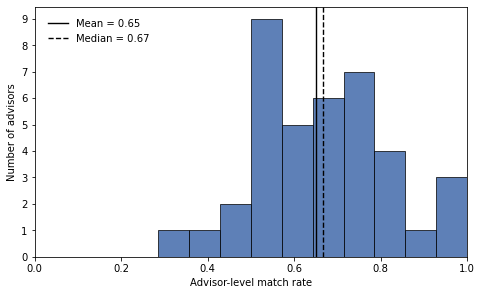

In [17]:
fig_hist= plot_advisor_homophily_distribution(
    advisor_het,
    outpath_prefix="fig_53_advisor_matchrate.pdf",
    show=True
)

### 5.4 Advisor undergraduate origin and student composition

In [18]:
def build_pairs_with_advisor_ug_from_people(people: pd.DataFrame, strict_student_rows: bool = True) -> pd.DataFrame:
    """
    Builds student rows with advisor UG country attached (forward-filled from professor row).
    Requires people has UG_Country for both professors and students.
    Output columns:
      Advisor_ID, Destination_Program, Advisor_UG_Country_std, Student_UG_Country_std
    """
    df = people.copy()
    role = df["Role"].astype(str).str.strip().str.lower()
    df["_role_norm"] = role

    prof_pat = "|".join(["prof", "faculty", "assistant professor", "associate professor", "full professor"])
    df["_is_prof"] = df["_role_norm"].str.contains(prof_pat, na=False)

    stud_pat = "|".join(["phd", "student", "doctoral"])
    df["_is_student"] = df["_role_norm"].str.contains(stud_pat, na=False)

    df["Advisor_Name"] = np.where(df["_is_prof"], df["Name"], pd.NA)
    df["Advisor_Institution"] = np.where(df["_is_prof"], df["Institution"], pd.NA)
    df["Advisor_UG_Country_raw"] = np.where(df["_is_prof"], df["UG_Country"], pd.NA)

    df[["Advisor_Name", "Advisor_Institution", "Advisor_UG_Country_raw"]] = (
        df[["Advisor_Name", "Advisor_Institution", "Advisor_UG_Country_raw"]].ffill()
    )

    if strict_student_rows:
        pairs = df[df["_is_student"]].copy()
    else:
        pairs = df[~df["_is_prof"]].copy()

    pairs = pairs.dropna(subset=["Advisor_Name", "Advisor_Institution"]).copy()

    pairs["Advisor_ID"] = (
        pairs["Advisor_Name"].astype("string").str.strip()
        + " | "
        + pairs["Advisor_Institution"].astype("string").str.strip()
    )
    pairs["Destination_Program"] = pairs["Advisor_Institution"].astype("string").str.strip()

    pairs["Advisor_UG_Country_std"] = std_country_series(pairs["Advisor_UG_Country_raw"])
    pairs["Student_UG_Country_std"] = std_country_series(pairs["UG_Country"])

    return pairs


def advisor_ug_country_test_from_people(
    people: pd.DataFrame,
    focal_country: str = "China",
    min_students: int = 3,
    n_perm: int = 2000,
    seed: int = 7,
) -> dict:
    """
    Table 1 style test:
      P(Student focal | Advisor focal) - P(Student focal | Advisor nonfocal),
    with student labels permuted within Destination_Program.
    """
    pairs = build_pairs_with_advisor_ug_from_people(people, strict_student_rows=True)

    w = pairs.dropna(
        subset=["Advisor_UG_Country_std", "Student_UG_Country_std", "Destination_Program", "Advisor_ID"]
    ).copy()

    counts = (
        w.groupby("Advisor_ID")["Student_UG_Country_std"]
         .size()
         .rename("n_students_known_country")
         .reset_index()
    )
    w = w.merge(counts, on="Advisor_ID", how="left")
    w = w[w["n_students_known_country"] >= int(min_students)].copy()

    is_adv_focal = (w["Advisor_UG_Country_std"] == focal_country).to_numpy()
    student_c = w["Student_UG_Country_std"].to_numpy()

    def diff(arr):
        is_student_focal = (arr == focal_country)
        p1 = is_student_focal[is_adv_focal].mean() if is_adv_focal.any() else np.nan
        p0 = is_student_focal[~is_adv_focal].mean() if (~is_adv_focal).any() else np.nan
        return p1, p0, p1 - p0

    obs_p1, obs_p0, obs_diff = diff(student_c)

    rng = np.random.default_rng(seed)
    group_indices = list(w.groupby("Destination_Program", sort=False).indices.values())

    null = np.empty(n_perm, dtype=float)
    for b in range(n_perm):
        shuffled = student_c.copy()
        for idx in group_indices:
            shuffled[idx] = rng.permutation(shuffled[idx])
        _, _, null[b] = diff(shuffled)

    null_mean = null.mean()
    p = (np.sum(np.abs(null - null_mean) >= np.abs(obs_diff - null_mean)) + 1) / (n_perm + 1)

    return {
        "focal_country": focal_country,
        "n_pairs_used": int(len(w)),
        "n_advisors_used": int(w["Advisor_ID"].nunique()),
        "min_students": int(min_students),
        "obs_p_student_focal_given_adv_focal": float(obs_p1),
        "obs_p_student_focal_given_adv_nonfocal": float(obs_p0),
        "obs_diff": float(obs_diff),
        "null_mean_diff": float(null_mean),
        "null_ci95_diff": (float(np.quantile(null, 0.025)), float(np.quantile(null, 0.975))),
        "p_value": float(p),
    }


res_54_china = advisor_ug_country_test_from_people(people, focal_country="China", min_students=3, n_perm=2000, seed=7)
res_54_usa = advisor_ug_country_test_from_people(people, focal_country="United States", min_students=3, n_perm=2000, seed=7)

pd.DataFrame([res_54_china, res_54_usa])[
    [
        "focal_country",
        "n_pairs_used",
        "n_advisors_used",
        "obs_p_student_focal_given_adv_focal",
        "obs_p_student_focal_given_adv_nonfocal",
        "obs_diff",
        "null_mean_diff",
        "null_ci95_diff",
        "p_value",
    ]
]

,focal_country,n_pairs_used,n_advisors_used,obs_p_student_focal_given_adv_focal,obs_p_student_focal_given_adv_nonfocal,obs_diff,null_mean_diff,null_ci95_diff,p_value
0,China,268,54,0.696429,0.230769,0.465659,0.215690,"(0.1282051282051282, 0.3122710622710622)",0.000500
1,United States,268,54,0.424242,0.198020,0.226223,0.100163,"(-0.015001500150015001, 0.20612061206120613)",0.029485


## 6. Sensitivity analyses

### 6.1 Minimum roster size thresholds (redo 5.1–5.4 for n_min = 2 and 4)

In [ ]:
def run_51_thresholds(people: pd.DataFrame, thresholds=(2, 3, 4), strict_student_rows=True):
    results = {}
    pairs = build_pairs_from_people(people, strict_student_rows=strict_student_rows)

    for k in thresholds:
        df_pairs_k, advisor_profiles_k = define_advisor_recruiting_profiles_from_pairs(pairs, min_students=int(k))
        w = df_pairs_k[df_pairs_k["is_stable"] == True].dropna(
                subset=["Student_UG_Country_std", "Advisor_Dominant_UG_Country", "Advisor_Institution"]
        )
        results[int(k)] = {
            "pairs": pairs,
            "df_pairs": df_pairs_k,
            "advisor_profiles": advisor_profiles_k,
            "table_51": table_51_from_df_pairs(df_pairs_k),
            # "n_pairs_stable": int((df_pairs_k["is_stable"] == True).sum()),
            # "n_advisors_stable": int(df_pairs_k.loc[df_pairs_k["is_stable"] == True, "Advisor_ID"].nunique()),

            "n_pairs_stable": int(len(w)),
            "n_advisors_stable": int(w["Advisor_ID"].nunique()),

        }
    return results


def rerun_52_for_thresholds(runs_51: dict, thresholds=(2, 3, 4), n_perm=2000, seed=7, shuffle_within="Advisor_Institution"):
    rows = []
    for k in thresholds:
        res, _ = country_homophily_test(runs_51[int(k)]["df_pairs"], n_perm=n_perm, seed=seed, shuffle_within=shuffle_within)
        rows.append({"min_students": int(k), **res})
    return pd.DataFrame(rows).sort_values("min_students")


def rerun_53_for_thresholds(runs_51: dict, thresholds=(2, 3, 4)):
    rows = []
    tables = {}
    for k in thresholds:
        by_adv = advisor_homophily_distribution(runs_51[int(k)]["df_pairs"])
        tables[int(k)] = by_adv
        x = by_adv["match_rate"].to_numpy()
        rows.append({
            "min_students": int(k),
            "n_advisors": int(len(by_adv)),
            "mean_match_rate": float(np.mean(x)),
            "median_match_rate": float(np.median(x)),
            "p10": float(np.quantile(x, 0.10)),
            "p90": float(np.quantile(x, 0.90)),
            "share_perfect": float(np.mean(x == 1.0)),
            "share_zero": float(np.mean(x == 0.0)),
        })
    return tables, pd.DataFrame(rows).sort_values("min_students")


def rerun_54_thresholds(people: pd.DataFrame, thresholds=(2, 3, 4), focal_countries=("China", "United States"), n_perm=2000, seed=7):
    rows = []
    for k in thresholds:
        for fc in focal_countries:
            res = advisor_ug_country_test_from_people(people, focal_country=fc, min_students=int(k), n_perm=n_perm, seed=seed)
            res["min_students"] = int(k)
            rows.append(res)
    out = pd.DataFrame(rows).sort_values(["min_students", "focal_country"])
    return out


runs_51 = run_51_thresholds(people, thresholds=(2, 3, 4), strict_student_rows=True)

# 5.1 redo tables
print("5.1 sample sizes by threshold")
for k in (2, 3, 4):
    print(f"n_min={k}: stable_pairs={runs_51[k]['n_pairs_stable']} | stable_advisors={runs_51[k]['n_advisors_stable']}")

display(runs_51[2]["table_51"].head(20))
display(runs_51[4]["table_51"].head(20))

# 5.2 redo
summary_52 = rerun_52_for_thresholds(runs_51, thresholds=(2, 3, 4), n_perm=2000, seed=7, shuffle_within="Advisor_Institution")
display(summary_52)

# 5.3 redo
advisor_tables_53, summary_53 = rerun_53_for_thresholds(runs_51, thresholds=(2, 3, 4))
display(summary_53)

# 5.4 redo
summary_54 = rerun_54_thresholds(people, thresholds=(2, 3, 4), focal_countries=("China", "United States"), n_perm=2000, seed=7)
display(summary_54[[
    "min_students",
    "focal_country",
    "n_pairs_used",
    "n_advisors_used",
    "obs_p_student_focal_given_adv_focal",
    "obs_p_student_focal_given_adv_nonfocal",
    "obs_diff",
    "null_mean_diff",
    "null_ci95_diff",
    "p_value",
]])

5.1 sample sizes by threshold
n_min=2: stable_pairs=217 | stable_advisors=43
n_min=3: stable_pairs=209 | stable_advisors=39
n_min=4: stable_pairs=191 | stable_advisors=33


,Advisor_Dominant_UG_Country_std,n_advisors,n_pairs
0,China,24,136
3,United States,15,69
1,Iran,3,10
2,South Korea,1,2


,Advisor_Dominant_UG_Country_std,n_advisors,n_pairs
0,China,21,128
2,United States,11,58
1,Iran,1,5


,min_students,n_pairs_used,n_advisors_used,obs_match_rate,null_mean_match_rate,null_ci95,p_value,lift_over_null
0,2,213,43,0.666667,0.527150,"(0.4835680751173709, 0.5727699530516432)",0.0005,0.139516
1,3,205,39,0.653659,0.527851,"(0.48292682926829267, 0.5707317073170731)",0.0005,0.125807
2,4,187,33,0.652406,0.539987,"(0.49732620320855614, 0.5828877005347594)",0.0005,0.112420


,min_students,n_advisors,mean_match_rate,median_match_rate,p10,p90,share_perfect,share_zero
0,2,43,0.682484,0.666667,0.500000,1.000000,0.162791,0.0
1,3,39,0.649919,0.666667,0.485714,0.844444,0.076923,0.0
2,4,33,0.646873,0.600000,0.442857,0.877778,0.090909,0.0


,min_students,focal_country,n_pairs_used,n_advisors_used,obs_p_student_focal_given_adv_focal,obs_p_student_focal_given_adv_nonfocal,obs_diff,null_mean_diff,null_ci95_diff,p_value
0,2,China,294,67,0.692982,0.238889,0.454094,0.221279,"(0.1388888888888889, 0.3108187134502924)",0.000500
1,2,United States,294,67,0.407895,0.192661,0.215234,0.096316,"(0.0022935779816513624, 0.1974891356832448)",0.022489
2,3,China,268,54,0.696429,0.230769,0.465659,0.215690,"(0.1282051282051282, 0.3122710622710622)",0.000500
3,3,United States,268,54,0.424242,0.198020,0.226223,0.100163,"(-0.015001500150015001, 0.20612061206120613)",0.029485
4,4,China,220,38,0.697248,0.252252,0.444995,0.235560,"(0.1540623191999339, 0.33589552855607907)",0.000500
5,4,United States,220,38,0.452381,0.196629,0.255752,0.124976,"(-0.009095773140716967, 0.25575173889780634)",0.078961


### 6.2 Influence of Large Advisors

In [20]:
import numpy as np
import pandas as pd

def exclude_top_advisors_by_roster(
    df_pairs: pd.DataFrame,
    top_frac: float = 0.05,
    count_known_ug_only: bool = True,
    student_country_col: str = "Student_UG_Country_std",
) -> dict:
    """
    6.2: exclude the top X fraction of advisors by roster size.

    Roster size is counted as:
      count_known_ug_only=True  -> number of linked students with nonmissing student UG country
      count_known_ug_only=False -> number of linked students (all pairs)

    Returns dict with:
      df_filtered, excluded_advisors, roster_counts, cutoff_count
    """
    w = df_pairs.copy()

    if count_known_ug_only:
        w_count = w.dropna(subset=[student_country_col]).copy()
    else:
        w_count = w.copy()

    roster_counts = (
        w_count.groupby("Advisor_ID")
               .size()
               .rename("n_linked_students")
               .reset_index()
    )

    if len(roster_counts) == 0:
        raise ValueError("No advisors available to compute roster sizes.")

    cutoff = float(np.quantile(roster_counts["n_linked_students"], 1.0 - top_frac))
    excluded = roster_counts.loc[roster_counts["n_linked_students"] >= cutoff, "Advisor_ID"].tolist()

    df_filtered = w.loc[~w["Advisor_ID"].isin(excluded)].copy()

    return {
        "df_filtered": df_filtered,
        "excluded_advisors": excluded,
        "roster_counts": roster_counts.sort_values("n_linked_students", ascending=False),
        "cutoff_count": cutoff,
        "n_excluded_advisors": len(excluded),
        "share_excluded_advisors": len(excluded) / roster_counts["Advisor_ID"].nunique(),
    }


def run_62_influence_large_advisors(
    df_pairs: pd.DataFrame,
    top_frac: float = 0.05,
    count_known_ug_only: bool = True,
    n_perm: int = 2000,
    seed: int = 7,
    shuffle_within: str = "Advisor_Institution",
):
    """
    Reruns the main homophily test (5.2) after excluding top 5 percent advisors by roster size.

    Requires country_homophily_test(df_pairs, ...) to be defined.
    Returns a small comparison table plus the filtered df and metadata.
    """
    base_res, _ = country_homophily_test(
        df_pairs, n_perm=n_perm, seed=seed, shuffle_within=shuffle_within
    )

    filt = exclude_top_advisors_by_roster(
        df_pairs, top_frac=top_frac, count_known_ug_only=count_known_ug_only
    )
    df_f = filt["df_filtered"]

    drop_res, _ = country_homophily_test(
        df_f, n_perm=n_perm, seed=seed, shuffle_within=shuffle_within
    )

    comp = pd.DataFrame([
        {"spec": "baseline", **base_res},
        {"spec": f"exclude_top_{int(top_frac*100)}pct_advisors", **drop_res},
    ])

    meta = {
        "cutoff_count": filt["cutoff_count"],
        "n_excluded_advisors": filt["n_excluded_advisors"],
        "share_excluded_advisors": filt["share_excluded_advisors"],
    }

    return comp, meta, df_f, filt


# ----------------------
# Example run (baseline n_min=3 df_pairs)
# ----------------------
comp_62, meta_62, df_pairs_62, filt_62 = run_62_influence_large_advisors(
    df_pairs,
    top_frac=0.05,
    count_known_ug_only=True,     # consistent with your stability logic
    n_perm=2000,
    seed=7,
    shuffle_within="Advisor_Institution",
)

print("6.2 meta:", meta_62)
display(comp_62)


# Optional: also rerun 5.3 heterogeneity on the filtered sample
advisor_het_base = advisor_homophily_distribution(df_pairs)
advisor_het_62 = advisor_homophily_distribution(df_pairs_62)

print("5.3 advisors baseline:", len(advisor_het_base), "filtered:", len(advisor_het_62))
display(advisor_het_62.head(25))


6.2 meta: {'cutoff_count': 8.0, 'n_excluded_advisors': 5, 'share_excluded_advisors': 0.06493506493506493}


,spec,n_pairs_used,n_advisors_used,obs_match_rate,null_mean_match_rate,null_ci95,p_value,lift_over_null
0,baseline,205,39,0.653659,0.527851,"(0.48292682926829267, 0.5707317073170731)",0.0005,0.125807
1,exclude_top_5pct_advisors,179,36,0.631285,0.488894,"(0.44120111731843575, 0.5363128491620112)",0.0005,0.142391


5.3 advisors baseline: 39 filtered: 36


,Advisor_ID,n_students,match_rate,dominant_country,dom_share,destination_program
11,220 | Purdue University,5,1.000000,China,1.000000,Purdue University
27,414 | Johns Hopkins University,5,1.000000,China,1.000000,Johns Hopkins University
18,326 | UC Davis,6,0.833333,China,0.833333,UC Davis
23,388 | Columbia University,5,0.800000,China,0.800000,Columbia University
26,41 | MIT,5,0.800000,United States,0.800000,MIT
32,77 | University of Michigan Ann Arbor,5,0.800000,United States,0.800000,University of Michigan Ann Arbor
1,103 | Georgia Institute of Technology,4,0.750000,United States,0.750000,Georgia Institute of Technology
29,426 | Penn State University,4,0.750000,China,0.750000,Penn State University
31,72 | University of Michigan Ann Arbor,4,0.750000,China,0.750000,University of Michigan Ann Arbor
13,241 | Purdue University,7,0.714286,China,0.714286,Purdue University


### 6.3 Excude Chinese Students

In [21]:
import numpy as np
import pandas as pd

def exclude_students_by_ug_country(
    df_pairs: pd.DataFrame,
    excluded_countries=("China",),
    student_country_col: str = "Student_UG_Country_std",
) -> pd.DataFrame:
    """
    Drops advisor–student pair rows where the student's UG country is in excluded_countries.
    """
    w = df_pairs.copy()
    sc = w[student_country_col].astype("string").str.strip()
    w = w.loc[~sc.isin(list(excluded_countries))].copy()
    return w


def run_63_excluding_chinese_students(
    df_pairs: pd.DataFrame,
    n_perm: int = 2000,
    seed: int = 7,
    shuffle_within: str = "Advisor_Institution",
):
    """
    6.3: rerun 5.2 (and optionally 5.3) after excluding students with Chinese UG background.
    Requires:
      - country_homophily_test(...)
      - advisor_homophily_distribution(...)
    """
    # baseline 5.2
    base_52, _ = country_homophily_test(df_pairs, n_perm=n_perm, seed=seed, shuffle_within=shuffle_within)

    # filtered
    df_no_cn = exclude_students_by_ug_country(df_pairs, excluded_countries=("China",))
    filt_52, _ = country_homophily_test(df_no_cn, n_perm=n_perm, seed=seed, shuffle_within=shuffle_within)

    comp_52 = pd.DataFrame([
        {"spec": "baseline", **base_52},
        {"spec": "exclude_students_China", **filt_52},
    ])

    # 5.3 advisor heterogeneity (distribution) on filtered sample
    adv_base = advisor_homophily_distribution(df_pairs)
    adv_no_cn = advisor_homophily_distribution(df_no_cn)

    # small summary for text
    def _summ(by_adv: pd.DataFrame):
        x = by_adv["match_rate"].to_numpy()
        return {
            "n_advisors": int(len(by_adv)),
            "mean_match_rate": float(np.mean(x)) if len(x) else np.nan,
            "median_match_rate": float(np.median(x)) if len(x) else np.nan,
            "p10_p90": (float(np.quantile(x, 0.10)), float(np.quantile(x, 0.90))) if len(x) else (np.nan, np.nan),
            "share_perfect": float(np.mean(x == 1.0)) if len(x) else np.nan,
        }

    comp_53 = pd.DataFrame([
        {"spec": "baseline", **_summ(adv_base)},
        {"spec": "exclude_students_China", **_summ(adv_no_cn)},
    ])

    return comp_52, comp_53, df_no_cn, adv_no_cn


# ----------------------
# Example run (baseline n_min=3 df_pairs)
# ----------------------
comp_52_63, comp_53_63, df_pairs_no_cn, advisor_het_no_cn = run_63_excluding_chinese_students(
    df_pairs,
    n_perm=2000,
    seed=7,
    shuffle_within="Advisor_Institution",
)

display(comp_52_63)         # Section 6.3 main test rerun (5.2)
display(comp_53_63)         # Advisor-level alignment summary (5.3-style)
display(advisor_het_no_cn.head(25))


,spec,n_pairs_used,n_advisors_used,obs_match_rate,null_mean_match_rate,null_ci95,p_value,lift_over_null
0,baseline,205,39,0.653659,0.527851,"(0.48292682926829267, 0.5707317073170731)",0.000500,0.125807
1,exclude_students_China,106,36,0.415094,0.378906,"(0.33962264150943394, 0.41509433962264153)",0.075962,0.036189


,spec,n_advisors,mean_match_rate,median_match_rate,p10_p90,share_perfect
0,baseline,39,0.649919,0.666667,"(0.4857142857142857, 0.8444444444444447)",0.076923
1,exclude_students_China,36,0.309590,0.000000,"(0.0, 0.8)",0.083333


,Advisor_ID,n_students,match_rate,dominant_country,dom_share,destination_program
19,339 | UCLA,5,1.000000,United States,0.555556,UCLA
34,9 | Carnegie Mellon University,3,1.000000,United States,0.600000,Carnegie Mellon University
26,407 | University of Minnesota Twin Cities,2,1.000000,Iran,0.666667,University of Minnesota Twin Cities
27,41 | MIT,5,0.800000,United States,0.800000,MIT
32,77 | University of Michigan Ann Arbor,5,0.800000,United States,0.800000,University of Michigan Ann Arbor
1,103 | Georgia Institute of Technology,4,0.750000,United States,0.750000,Georgia Institute of Technology
4,131 | University of Washington,3,0.666667,United States,0.666667,University of Washington
6,151 | University of Texas Austin,3,0.666667,United States,0.500000,University of Texas Austin
7,156 | University of Texas Austin,3,0.666667,United States,0.666667,University of Texas Austin
21,349 | UCLA,3,0.666667,United States,0.666667,UCLA
